## Create test dataset
The goal in this notebook is to create a proper test dataset evaluate the model with completely unseen images.

We download new images from the internet by searching with the prompt "$BRAND shoes", where BRAND is one of "nike", "adidas" or "converse".

Images are also resized to match the training/valid.

In [1]:
from fastbook import *

In [2]:
path = Path(os.environ["PROJECTS"])/"shoes-classifier"
(path/"data").ls()

(#6) [Path('/home/fabrizio/projects/shoes-classifier/data/models'),Path('/home/fabrizio/projects/shoes-classifier/data/resnet18-fine-tuned-stage-1.pkl'),Path('/home/fabrizio/projects/shoes-classifier/data/.ipynb_checkpoints'),Path('/home/fabrizio/projects/shoes-classifier/data/test_extra'),Path('/home/fabrizio/projects/shoes-classifier/data/test'),Path('/home/fabrizio/projects/shoes-classifier/data/train')]

Let's check the size of the original images to later resize the new images to match that size

In [3]:
fns_train = get_image_files(path/"data"/"train")
fns_valid = get_image_files(path/"data"/"valid")
set(load_image(fn).size for fn in fns_train + fns_valid)

{(240, 240)}

Now let's download new data!

In [4]:
brands = ("nike", "adidas", "converse")

In [5]:
n_download = 200

In [6]:
test_path = mkdir(path/"data"/"test_extra", exist_ok=True)
data = {k: defaultdict() for k in brands}
for brand in brands:
    dest_dir_raw = test_path/"raw"/brand
    dest_dir = test_path/brand
    if dest_dir_raw.exists(): shutil.rmtree(dest_dir_raw)
    if dest_dir.exists(): shutil.rmtree(dest_dir)
    data[brand]["path_raw"] = mkdir(dest_dir_raw, parents=True)
    data[brand]["path"] = mkdir(dest_dir, parents=True)
    data[brand]["urls"] = search_images_ddg(f"{brand} shoes", n_download)

In [7]:
def resize_imgs_brand(brand):
    imgs = [(fn, load_image(fn).resize((240,240))) for fn in get_image_files(data[brand]["path_raw"])]
    assert imgs, "No images found!"
    failed = []
    for fn, img in imgs:
        try:
            img.save(data[brand]["path"]/f"resized_{fn.name}")
        except Exception as e:
            print(e)
            failed.append(fn)
    return failed

In [8]:
def rm(fns: list[Path]):
    for fn in failed: fn.unlink()

In [9]:
for brand in brands:
    dest_dir = data[brand]["path_raw"]
    download_images(dest_dir, urls=data[brand]["urls"])
    failed = verify_images(get_image_files(dest_dir))
    print(f"{brand}: removing {len(failed)} images")
    rm(failed)
    failed = resize_imgs_brand(brand)
    print(f"{brand}: removing {len(failed)} images during resize")
    rm(failed)

nike: removing 22 images
nike: removing 0 images during resize
adidas: removing 33 images
cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
adidas: removing 4 images during resize
converse: removing 7 images
converse: removing 0 images during resize


In [10]:
verify_images(get_image_files(data[brand]["path"]))

(#0) []

In [11]:
data[brand]["path_raw"].ls()[:2], data[brand]["path"].ls()[:2]

((#2) [Path('/home/fabrizio/projects/shoes-classifier/data/test_extra/raw/converse/a4cec7cc-fecd-424b-bf5f-61c5ea12d88d.jpg'),Path('/home/fabrizio/projects/shoes-classifier/data/test_extra/raw/converse/c677a745-9c06-43fd-b899-92472fb4a876.jpeg')],
 (#2) [Path('/home/fabrizio/projects/shoes-classifier/data/test_extra/converse/resized_3a70384c-eefe-4972-8610-8b9f107fa1cd.png'),Path('/home/fabrizio/projects/shoes-classifier/data/test_extra/converse/resized_0c43ac5d-1f8f-41a9-9196-d0873e592a45.jpeg')])

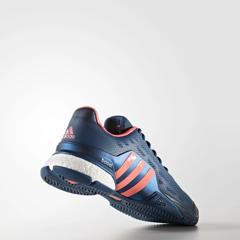

In [12]:
load_image(get_image_files(data["adidas"]["path"])[1])

In [13]:
for brand in brands:
    print(brand, len(data[brand]["path"].ls()))

nike 159
adidas 147
converse 170


Delete raw pictures

In [14]:
!ls {path/"data"/"test_extra"} 

adidas	converse  nike	raw


In [15]:
!rm -rf {path/"data"/"test_extra"/"raw"}

In [16]:
!tree -d {path/"data"/"test_extra"}

/home/fabrizio/projects/shoes-classifier/data/test_extra
├── adidas
├── converse
└── nike

3 directories
